$$\require{mhchem}$$       

# Treating catalyst deactivation

We are interested in catalytic cracking of oil to various products:
\begin{align}
\ce{Gas/oil(A)&->[k_A]Products}
\end{align}
The rate law is $r_A=k_AC_A^2$. Gas oil (A) is fed at a rate of 30 mol/min and a concentration
of 0.075 mol/dm$^3$. You can neglect pressure or volumetric flow rate changes along the reactor.
The catalyst is not allowed to leave the reactor. 

#### The reactor is a 100 L CSTR with 22 kg of catalyst. Calculate the steady-state concentration of A and the steady-state concentration of P. The reaction rate constant $k_A = 600\: dm^6/(kg_{cat}\cdot mol\cdot min)$ at 500 K; assume the reactor is held at 500 K.

In [1]:
import numpy as np
from scipy.optimize import fsolve

V = 100. # L
Fa0 = 30. # mol/min
Ca0 = 0.075 # mol/dm^3
v0 = Fa0/Ca0 # L/min
ka = 600. # L^6/(kg-mol-min)
mcat = 22. # kg

def dCdt(C):
    Ca, Cp = C
    r = mcat*ka*Ca**2
    dCadt = v0*(Ca0-Ca) - r
    dCpdt = r - v0*Cp
    dCdt = [dCadt, dCpdt]
    return dCdt
    
sol = fsolve(dCdt, [10, 1])

print('Steady-state concentrations:\n Ca = %1.4f mol/L \n Cp = %1.4f mol/L' % tuple(sol))

Steady-state concentrations:
 Ca = 0.0349 mol/L 
 Cp = 0.0401 mol/L


#### We know that the catalyst activity decreases over time due to deactivation so we need to model this as a transient CSTR  starting with A at 0.075 mol/dm$^3$ an P at 0.010 mol/dm$^3$. The reaction rate decays as $k_A=k_A^0 \exp(- k_D t)$ where $k_D=0.72$/min, $t$ is time, and $k_A^0$ is the rate constant at 500 K (above). Calculate the concentration profile of A and the products P for the first 20 min.

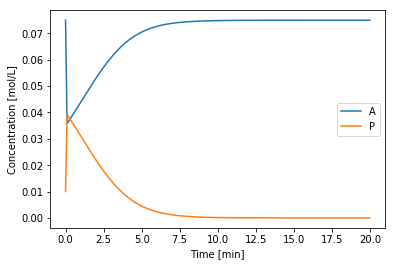

In [2]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

ka0 = 600. # L^6/(kg-mol-min)
kd = 0.72 # 1/min

def dCdt(C, t):
    Ca, Cp = C
    ka = ka0*np.exp(-kd*t)
    r = mcat*ka*Ca**2
    dCadt = v0*(Ca0-Ca) - r
    dCpdt = r - v0*Cp
    dCdt = [dCadt, dCpdt]
    return dCdt
    
tspan = np.linspace(0, 20, 200)
sol = odeint(dCdt, [0.075, 0.01], tspan)

plt.plot(tspan,sol)
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mol/L]')
plt.legend(['A', 'P'])
plt.show()

#### You plan to combat the effects of the catalyst decay by increasing the temperature over time.  The activation energy for the reaction is 10 kJ/mol.  Calculate and plot the transient temperature profile necessary to maintain the reactor conversion at the steady state value. The maximum safe temperature for the reactor and process is 1000 K. How long can you maintain this process before violating safety temperature limits and having to recharge the catalyst?

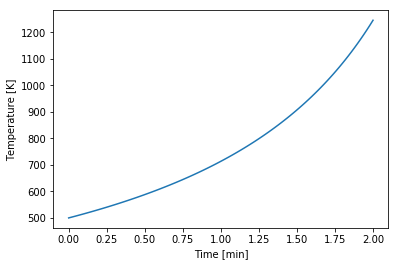

We can maintain the process for 1.67 minutes


In [3]:
Ea = 10000. # J/mol
R = 8.314 # J/mol-K

@np.vectorize
def kfun(T, t):
    '''
    This function calculates the rate constant given the time (which affects decay)
    and the temperature (which we control). It then returns the different between
    ka0 and k so that we can find the Temperature we need to mainain a constant rate... constant.
    '''
    k = ka0 * np.exp(-Ea/R*(1/T-1/500)) * np.exp(-kd*t)
    return ka0 - k

# Calculate the transient temperature profile
tspan = np.linspace(0, 2, 100)
Tlist = []
for t in tspan:
    sol = fsolve(kfun, 500, t)
    Tlist.append(sol)
    
# Plot
plt.plot(tspan, Tlist)
plt.xlabel('Time [min]')
plt.ylabel('Temperature [K]')
plt.show()

# Calculate the maximum time we can maintain the rate constant safely
def tfun(t):
    T = fsolve(kfun, 500, t)
    return 1000 - T
time_limit = fsolve(tfun, 2)
print('We can maintain the process for %.2f minutes' % time_limit)

#### You suggest moving to a moving, packed bed reactor configuration, where the catalyst moves along the reactor length co-currently with the reactants, but at a specified flow rate $U_s$ of $10\:kg/min$.  The packed bed reactor still contains 22 kg of catalyst at all times. You can model this as a normal packed bed reactor, with the rate constant for the catalyst at a specific point in the reactor calculated from its residence time, $\tau$:  $k_A=k_A^0\exp(-k_D\tau)$. This residence time can be calculated as a function of the total mass of catalyst that the reactants have seen, $W$:  $\tau(W)=W/U_s$. Plot the molar flowrate of species A and P as a function of $W$. Assume that we will use a constant reactor temperature of 500 K.

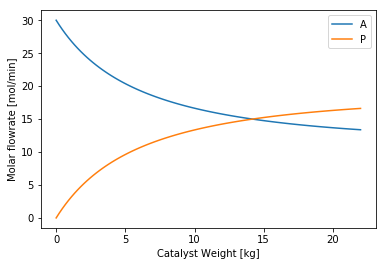

In [4]:
Us = 10. # kg/min

def dFdW(F, W):
    Fa, Fp = F
    Ca = Fa/v0
    tau = W/Us
    ka = ka0*np.exp(-kd*tau)
    r = ka*Ca**2
    dFadW = -r
    dFpdW = r
    return [dFadW, dFpdW]

Wspan = np.linspace(0, 22, 100)
sol = odeint(dFdW, [Fa0, 0], Wspan)

plt.plot(Wspan, sol)
plt.xlabel('Catalyst Weight [kg]')
plt.ylabel('Molar flowrate [mol/min]')
plt.legend(['A', 'P'])
plt.show()

#### With your new reactor configuration, find the optimal reactant flow rate $v_0$ and catalyst feed rate $U_s$ to maximize profit, and report this profit. Assume you're going to sell all product you make.
Useful information:
- It costs $\$25,000/hr$ to operate the moving bed reactor.
- The gas/oil feed costs \$50/mol.
- Bulk catalyst material costs \$150/kg.
- The products sell for \$200/mol (on an equivalent basis per mol of gas/oil).

Tip: it can help to plot profit as a function of Us and v0 using plt.contour to help identify what is reasonable, just as we did in the bonus for HW5.

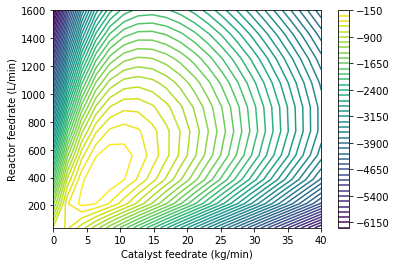

Profit will be maximized at $3.90/min when setting Us = 7.27 kg/min and v0 = 403 L/min


In [5]:
cat_cost = 150. # $/kg
operational_cost = 25000./60 # $/min
product_price = 200. # $/mol
reactant_cost = 50. # $/mol

@np.vectorize
def profit(Us, v0):
    '''
    Profit will be a function of Us and v0. It's also going to be a function of how
    much reactant we convert to product. So first, we need to calculate the outlet
    flowrate of product, which we know how to do from before.
    '''
    # Define a differential function for the molal flowrate, just as we did before
    def dFdW(F, W):
        Fa, Fp = F
        Ca = Fa/v0
        tau = W/Us
        ka = ka0*np.exp(-kd*tau)
        r = ka*Ca**2
        dFadW = -r
        dFpdW = r
        return [dFadW, dFpdW]
    # Integrate the differential throughout the length of the reactor to find the outlet
    # flowrate of product, Pf_final
    Wspan = np.linspace(0, 22, 20)
    sol = odeint(dFdW, [v0*Ca0, 0], Wspan)
    Fp_final = sol[-1, 1]
    # Calculate and return the profit given the revenue and costs
    revenue = product_price*Fp_final
    cost = operational_cost + reactant_cost*v0*Ca0 + cat_cost*Us
    profit = revenue - cost
    return profit

# Define ranges to plot Us and v0. Then make a mesh and calculate the profit at each
# point on the mesh.
Usrange = np.linspace(0.001, 40, 20)
v0range = np.linspace(v0/10, v0*4, 10)
Usgrid, v0grid = np.meshgrid(Usrange, v0range)
profits = profit(Usgrid, v0grid)

# Make the contour plot
fig, ax = plt.subplots()
p = ax.contour(Usrange, v0range, profits, 50)
cb = fig.colorbar(p)
plt.xlabel('Catalyst feedrate (kg/min)')
plt.ylabel('Reactor feedrate (L/min)')
plt.show()

# Now that we have a contour plot, we can make a good guess for `scipy.optimize.minimize`
from scipy.optimize import minimize
sol = minimize(lambda x: -profit(x[0], x[1]), [8, 400])
print('Profit will be maximized at $%1.2f/min when setting Us = %.2f kg/min and v0 = %.0f L/min'
      % (-sol.fun, sol.x[0], sol.x[1]))

#### You complain to your catalyst vendor about how fast the catalyst deactivates, and they suggest you try their new SuperPremium+++ catalyst. It costs \$250/kg but is more resilient and has an improved deactivation rate constant of $k_D=0.3$/min. Will this change be worth it? Decide by calculating the expected profit with this new catalyst.

In [6]:
# Time for some copying and pasting!

cat_cost = 250. # $/kg
kd = 0.3 # 1/min

@np.vectorize
def profit(Us, v0):
    '''
    Profit will be a function of Us and v0. It's also going to be a function of how
    much reactant we convert to product. So first, we need to calculate the outlet
    flowrate of product, which we know how to do from before.
    '''
    # Define a differential function for the molal flowrate, just as we did before
    def dFdW(F, W):
        Fa, Fp = F
        Ca = Fa/v0
        tau = W/Us
        ka = ka0*np.exp(-kd*tau)
        r = ka*Ca**2
        dFadW = -r
        dFpdW = r
        return [dFadW, dFpdW]
    # Integrate the differential throughout the length of the reactor to find the outlet
    # flowrate of product, Pf_final
    Wspan = np.linspace(0, 22, 20)
    sol = odeint(dFdW, [v0*Ca0, 0], Wspan)
    Fp_final = sol[-1, 1]
    # Calculate and return the profit given the revenue and costs
    revenue = product_price*Fp_final
    cost = operational_cost + reactant_cost*v0*Ca0 + cat_cost*Us
    profit = revenue - cost
    return profit
sol = minimize(lambda x: -profit(x[0], x[1]), [8, 400])
print('Profit will be maximized at $%1.2f/min when setting Us = %.2f kg/min and v0 = %.0f L/min'
      % (-sol.fun, sol.x[0], sol.x[1]))

Profit will be maximized at $406.10/min when setting Us = 4.38 kg/min and v0 = 511 L/min


We should definitely use SuperPremium+++, since it will increase our profits by two orders of magnitude.

# Catalyst particles

A first-order heterogeneous irreversible reaction is taking place within a spherical catalyst pellet that is plated with platinum throughout the pellet. The reactant concentration halfway between the external surface and the center of the pellet ($r=R/2$) is equal to one tenth the concentration of the pellet's external surface.  The concentration at the external surface is 0.001 g mol /dm^3, the diameter (2R) is $2\times 10^{-3}$cm, and the diffusion coefficient is 0.1 $cm^2/s$.
\begin{align*}
\ce{A->B}
\end{align*}

#### What is the concentration of reactant at a distance of $3\times 10^{-4}$ cm in from the external pellet surface?

#### To what diameter should the pellet be reduced if the effectiveness factor is to be 0.8? 